[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PepeLira/car_trajectory_extractor/blob/main/video_stabilizer/Parte1_Alineamiento_de_Fotogramas_José_Lira.ipynb)

# 1. Demostración Alineamiento de Fotogramas con el algoritmo SIFT

Este Colab busca estudiar metodologías con el objetivo de alinear los frames de videos y presentar un cuadro estático sin cambios significativos en la posición de la cámara o los objetos en la escena. Para este analisis se presume que los movimientos pueden ser modeladas como una transformación afín, permitiendo 4 grados de livertad,
dentro de las que se incluyen desplazamientos, rotaciones y escalamiento.

El procedimiento planteado consta de las siguientes etapas:

1. Extracción de Fotogramas de video
2. Selección de Fotogramas de Referencia
3. Alineamiento de Fotogramas


Para poder realizar esta tarea se plantean los siguientes pasos:

1. Extracción de Características de cada imagen: para esto se utiliza el algoritmo SIFT (Scale-Invariant Feature Transform) disponible en la librería OpenCV.
2. Comparar y Emparejar características entre pares de frames: para esto utilizamos el algoritmo BFmatcher el cual usando "fuerza bruta" (comparando cada descriptor uno a uno) obtiene la distancia entre cada descriptor mediante hamming dado que los descriptores son binarios.
3. Filtrar las Parejas de características: con el objetivo de estudiar cuantas características son necesarias para cumplir con el objetivo.
4. Extraer los key points de cada descriptor
5. Calcular la matriz de transformación afín, para cada característica (keypoint + descriptor).
6. Ponderar la matriz con el frame de la secuencia para alinear con respecto al frame de referencia

### Paso 1: Declaramos las dependencias

In [3]:
# En caso de que se este trabajando en Google Colab
# import sys
# if 'google.colab' in sys.modules:

In [4]:
from random import randrange
import matplotlib.pyplot as plt
import numpy as np
import cv2
figsize = (10, 10)

In [5]:
# Declaramos el path del Video a trabajar y el número de features a extraer

VIDEO_PATH = "./video1_30s.mp4"

NFEATURES=None

### **(Opcional)** Subir Video de Prueba para colab

In [6]:
# from google.colab import files
# from IPython.display import Video

# # Upload the video file
# uploaded = files.upload()

# # Get the file name of the uploaded video
# VIDEO_PATH = next(iter(uploaded))

# print(VIDEO_PATH)

### Paso 2: Declarar Funciones Básicas y la Extracción de Fotogramas de Prueba

Total Frames = 901


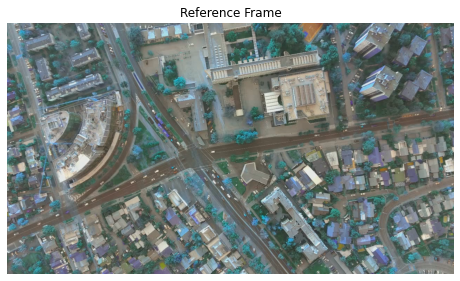

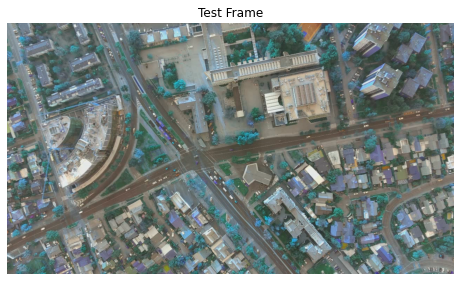

In [7]:
def show_image_with_caption(image, caption = None):
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.title(caption)
    plt.axis('off')
    plt.show()

def extract_frame(video_path, frame_n):
  # Open the video file
  video_capture = cv2.VideoCapture(video_path)

  total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))

  if total_frames >= frame_n and frame_n > 0:
    # Set the start frame
    video_capture.set(cv2.CAP_PROP_POS_FRAMES, frame_n)

    # Read the frame
    _, frame = video_capture.read()

    return frame, total_frames
  else:
    return None
  
reference_frame, total_frames = extract_frame(VIDEO_PATH, 1)
test_frame, _ = extract_frame(VIDEO_PATH, 500)

gray_t = cv2.cvtColor(test_frame, cv2.COLOR_RGB2GRAY)
gray_r = cv2.cvtColor(reference_frame, cv2.COLOR_RGB2GRAY)

print(f"Total Frames = {total_frames}")
show_image_with_caption(reference_frame, "Reference Frame")
show_image_with_caption(test_frame, "Test Frame")

### Paso 3: Extraer Características

El algoritmo SIFT es un método comúnmente utilizado para la detección de características ... TODO

En concreto, se utiliza el método `detectAndCompute()` para extraer los ***Keypoints*** y los **Descriptores** asociados a cada imagen. Donde los Keypoints corresponden a las coordenadas de cada característica y los descriptores corresponden a una representación numérica que describe las características de una región o punto de interés en una imagen.

Los parámetros de interés en este método son:
#### Input
- `nfeatures`: Permite definir el número de características a extraer.
- `mask`: Permite definir una máscara sobre la cual se delimita la obtención de características.

#### Output
- `Keypoints`: arreglo de Coordenadas X Y de cada característica.
- `Descriptors`: arreglo de vectores Binarios 32bit, que representan el vecindario de cada característica.

A continuación extraemos las características de los dos fotogramas de prueba:

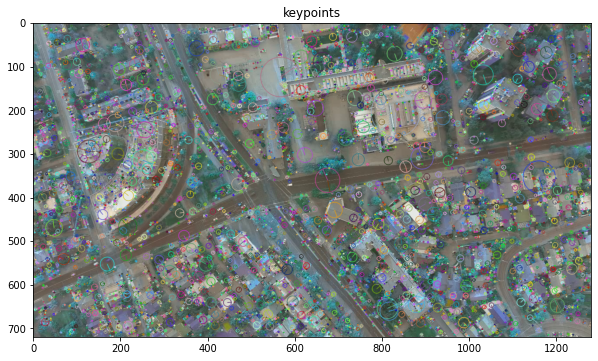

In [8]:
# use orb if sift is not installed
feature_extractor = cv2.SIFT_create(nfeatures=NFEATURES)

# find the keypoints and descriptors with chosen feature_extractor
keypoints1, descriptors1 = feature_extractor.detectAndCompute(gray_r, None)
keypoints2, descriptors2 = feature_extractor.detectAndCompute(gray_t, None)

test = cv2.drawKeypoints(reference_frame, keypoints1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=figsize)
plt.imshow(test)
plt.title("keypoints")
plt.show()



### Paso 4: Emparejar Características
Describir esta parte

Qué es knnMatch???

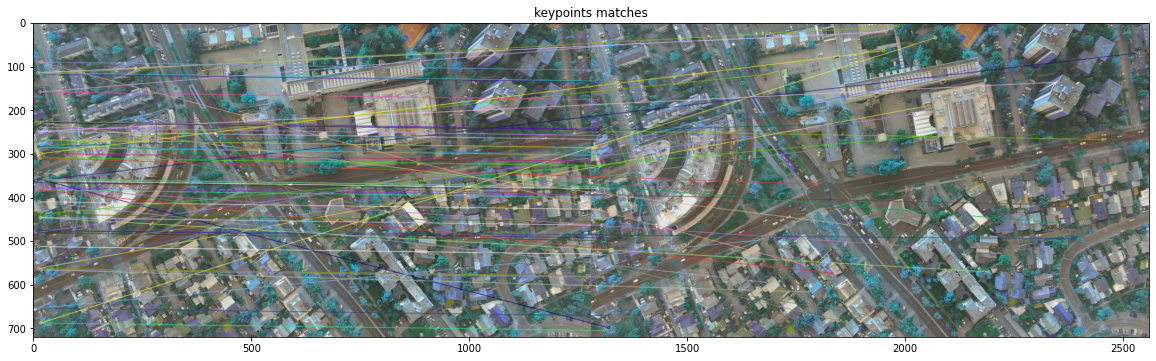

In [9]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# Apply ratio test
good_and_second_good_match_list = []
for m in matches:
    if m[0].distance/m[1].distance < 0.5:
        good_and_second_good_match_list.append(m)
good_match_arr = np.asarray(good_and_second_good_match_list)[:,0]

# show only 30 matches
im_matches = cv2.drawMatchesKnn(reference_frame, keypoints1, test_frame, keypoints2,
                                good_and_second_good_match_list[0:30], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20, 20))
plt.imshow(im_matches)
plt.title("keypoints matches")
plt.show()



### Paso 5: Encontrar Homografía en las Imágenes

Según el libro Computer Vision (Richard Szeliski), entendemos por Image Stitching el proceso necesario para sobreponer dos imagenes que representen un mismo cuadro. En este paso es necesario calcular la matriz que represente la transformación 2D afín entre las dos imagenes.

Para esto se utiliza el metodo `findHomography()` de openCV... continuar 

[cos(theta)*s, -sin(theta)*s, tx;  
 sin(theta)*s,  cos(theta)*s, ty]

Donde theta es el ángulo de rotación, s es el factor de escalamiento y tx, ty son translaciones en los ejes x, y respectivamente.

Luego usando el metodo `warpPerspective()` es posible aplicar la transformación de la matriz resultante sobre el frame comparado.

[[ 1.00662966e+00 -1.97281787e-02  1.38292420e+00]
 [ 2.37782992e-02  1.00528950e+00 -1.96790132e+01]
 [ 4.33274033e-06  3.85292720e-06  1.00000000e+00]]


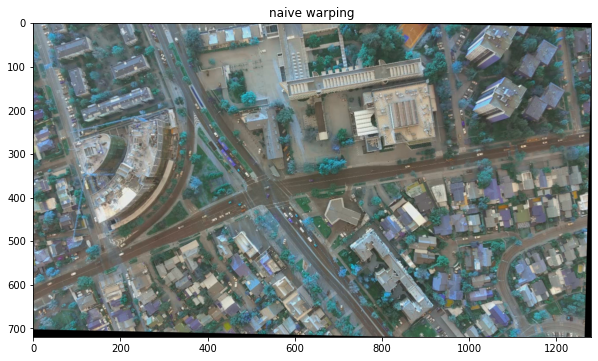

In [15]:
good_keypoints1 = np.array([keypoints1[m.queryIdx].pt for m in good_match_arr])
good_keypoints2 = np.array([keypoints2[m.trainIdx].pt for m in good_match_arr])
H, masked = cv2.findHomography(good_keypoints2, good_keypoints1, cv2.RANSAC, 5.0)

print(H)

test_frame_warped = cv2.warpPerspective(test_frame, H, (reference_frame.shape[1], reference_frame.shape[0]))
# test_frame_warped[0:reference_frame.shape[0], 0:reference_frame.shape[1]] = reference_frame

plt.figure(figsize=figsize)
plt.imshow(test_frame_warped)
plt.title("naive warping")
plt.show()
